In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import ERFutils
import scipy.signal as signal
import cf_xarray as cfxr
from datetime import timedelta

In [2]:
# Convolution error data
conv_1pctCO2_short = [(0.2134, 0.1526, 0.0294),(0.332, 0.2212, 0.0427),(0.3074, 0.2108, 0.015),(0.3277, 0.2243, 0.0183),(0.3601, 0.2428, 0.0201)]
conv_ssp126_short  = [(0.3695, 0.2918, 0.2593),(0.2269, 0.1635, -0.0038),(0.2344, 0.1672, 0.0426),(0.2288, 0.169, 0.0961),(0.2863, 0.2166, 0.1385)]
conv_ssp245_short  = [(0.2971, 0.2325, 0.161),(0.2532, 0.1779, -0.0458),(0.2283, 0.1629, -0.0037),(0.2018, 0.1496, 0.0471),(0.2541, 0.194, 0.0838)]
conv_ssp370_short  = [(0.2877, 0.2051, 0.0497),(0.2853, 0.199, -0.0819),(0.2528, 0.1784, -0.041),(0.1966, 0.1448, 0.0091),(0.2568, 0.1929, 0.0426)]
conv_ssp585_short  = [(0.264, 0.1942, 0.0246),(0.2924, 0.2005, -0.1144),(0.2546, 0.1777, -0.076),(0.2093, 0.1508, -0.0273),(0.2279, 0.1653, 0.0028)]

conv_1pctCO2_long = [(0.2472, 0.1787, -0.0287),(0.3642, 0.2213, -0.0451),(0.3171, 0.21, -0.0375),(0.3161, 0.2214, -0.0523),(0.3547, 0.2344, -0.0711)]
conv_ssp126_long  = [(0.5306, 0.3619, 0.2969),(0.2234, 0.1621, 0.0713),(0.2842, 0.2042, 0.1508),(0.48, 0.327, 0.2774),(0.5655, 0.373, 0.322)]
conv_ssp245_long  = [(0.3944, 0.2722, 0.1263),(0.2416, 0.169, -0.0086),(0.2108, 0.1517, 0.0488),(0.3384, 0.2362, 0.1535),(0.4045, 0.2708, 0.1785)]
conv_ssp370_long  = [(0.3519, 0.2404, -0.0875),(0.3508, 0.2204, -0.1121),(0.2926, 0.1848, -0.0722),(0.2334, 0.1704, 0.0181),(0.264, 0.1942, 0.0246)]
conv_ssp585_long  = [(0.3323, 0.2403, -0.0137),(0.3453, 0.2184, -0.0571),(0.297, 0.19, -0.0273),(0.2606, 0.1922, 0.0505),(0.2363, 0.1766, 0.0537)]

In [3]:
# Pattern error data
pattern_1pctCO2_short = [(0.2684, 0.1774, 0.0),(0.2465, 0.1658, -0.0),(0.249, 0.1683, 0.0),(0.2316, 0.1573, 0.0),(0.2471, 0.1734, 0.0)]
pattern_ssp126_short  = [(0.2197, 0.1525, 0.0),(0.1839, 0.1301, 0.0),(0.2106, 0.1456, 0.0),(0.204, 0.144, 0.0),(0.2129, 0.1481, 0.0)]
pattern_ssp245_short  = [(0.2111, 0.15, 0.0),(0.1951, 0.1379, 0.0),(0.2016, 0.1406, 0.0),(0.1809, 0.1285, 0.0),(0.1943, 0.1396, 0.0)]
pattern_ssp370_short  = [(0.2366, 0.1654, 0.0),(0.2156, 0.1502, 0.0),(0.2126, 0.147, 0.0),(0.1786, 0.1252, 0.0),(0.2002, 0.1436, 0.0)]
pattern_ssp585_short  = [(0.2289, 0.1527, 0.0),(0.2175, 0.1468, -0.0),(0.2164, 0.1475, -0.0),(0.1975, 0.1366, -0.0),(0.1998, 0.1402, -0.0)]

pattern_1pctCO2_long = [(0.2879, 0.1766, 0.0),(0.247, 0.1593, 0.0),(0.2311, 0.1512, 0.0),(0.2297, 0.1643, -0.0),(0.2313, 0.1682, 0.0)]
pattern_ssp126_long  = [(0.4642, 0.2627, 0.0),(0.1833, 0.1304, 0.0),(0.2055, 0.1402, 0.0),(0.3466, 0.2138, 0.0),(0.4289, 0.2418, 0.0)]
pattern_ssp245_long  = [(0.3789, 0.2211, 0.0),(0.1951, 0.1377, 0.0),(0.1766, 0.1245, 0.0),(0.2594, 0.1681, 0.0),(0.3241, 0.1938, 0.0)]
pattern_ssp370_long  = [(0.327, 0.2027, 0.0),(0.2201, 0.1514, 0.0),(0.1947, 0.1379, 0.0),(0.199, 0.1394, 0.0),(0.2491, 0.1682, 0.0)]
pattern_ssp585_long  = [(0.2961, 0.1813, -0.0),(0.227, 0.1506, -0.0),(0.2046, 0.1393, -0.0),(0.2017, 0.146, -0.0),(0.1969, 0.1385, -0.0)]

In [4]:
conv_all_short = [conv_1pctCO2_short,conv_ssp126_short,conv_ssp245_short,conv_ssp370_short,conv_ssp585_short]
conv_all_long = [conv_1pctCO2_long,conv_ssp126_long,conv_ssp245_long,conv_ssp370_long,conv_ssp585_long]

patt_all_short = [pattern_1pctCO2_short,pattern_ssp126_short,pattern_ssp245_short,pattern_ssp370_short,pattern_ssp585_short]
patt_all_long = [pattern_1pctCO2_long,pattern_ssp126_long,pattern_ssp245_long,pattern_ssp370_long,pattern_ssp585_long]

num_exp = len(conv_all_short)

In [5]:
save = False
if save:
    import pickle
    output_path = ERFutils.path_to_ERF_outputs
    with open(f'{output_path}conv_all_short.pickle', 'wb') as handle:
        pickle.dump(conv_all_short, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_path}conv_all_long.pickle', 'wb') as handle:
        pickle.dump(conv_all_long, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_path}patt_all_short.pickle', 'wb') as handle:
        pickle.dump(patt_all_short, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_path}patt_all_long.pickle', 'wb') as handle:
        pickle.dump(patt_all_long, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
RMSE_all_conv_short = np.zeros((num_exp,num_exp))
MAE_all_conv_short = np.zeros((num_exp,num_exp))
bias_all_conv_short = np.zeros((num_exp,num_exp))

RMSE_all_patt_short = np.zeros((num_exp,num_exp))
MAE_all_patt_short = np.zeros((num_exp,num_exp))
bias_all_patt_short = np.zeros((num_exp,num_exp))

RMSE_all_conv_long = np.zeros((num_exp,num_exp))
MAE_all_conv_long = np.zeros((num_exp,num_exp))
bias_all_conv_long = np.zeros((num_exp,num_exp))

RMSE_all_patt_long = np.zeros((num_exp,num_exp))
MAE_all_patt_long = np.zeros((num_exp,num_exp))
bias_all_patt_long = np.zeros((num_exp,num_exp))

for i in range(num_exp):
    for j in range(num_exp):
        RMSE_all_conv_short[i,j] = conv_all_short[i][j][0]
        MAE_all_conv_short[i,j] = conv_all_short[i][j][1]
        bias_all_conv_short[i,j] = conv_all_short[i][j][2]
        
        RMSE_all_patt_short[i,j] = patt_all_short[i][j][0]
        MAE_all_patt_short[i,j] = patt_all_short[i][j][1]
        bias_all_patt_short[i,j] = patt_all_short[i][j][2]
        
        RMSE_all_conv_long[i,j] = conv_all_long[i][j][0]
        MAE_all_conv_long[i,j] = conv_all_long[i][j][1]
        bias_all_conv_long[i,j] = conv_all_long[i][j][2]
        
        RMSE_all_patt_long[i,j] = patt_all_long[i][j][0]
        MAE_all_patt_long[i,j] = patt_all_long[i][j][1]
        bias_all_patt_long[i,j] = patt_all_long[i][j][2]

In [7]:
RMSE_all_conv_short[0] = [0.187, 0.2256, 0.2307, 0.2345, 0.2445]
MAE_all_conv_short[0] = [0.133, 0.159, 0.1615, 0.1654, 0.1739]
bias_all_conv_short[0] = [0.0109, 0.0173, 0.0109, 0.0223, 0.0204]

RMSE_all_conv_long[0] = [0.1885, 0.3015, 0.2278, 0.2563, 0.2861]
MAE_all_conv_long[0] = [0.1378, 0.1884, 0.1502, 0.1811, 0.1864]
bias_all_conv_long[0] = [-0.0081, 0.0074, 0.0017, 0.0004, -0.0135]


In [8]:
print(np.mean(MAE_all_conv_short))
print(np.mean(RMSE_all_conv_short))
print(np.mean(MAE_all_patt_short))
print(np.mean(RMSE_all_patt_short))
print()
print(np.mean(MAE_all_conv_long))
print(np.mean(RMSE_all_conv_long))
print(np.mean(MAE_all_patt_long))
print(np.mean(RMSE_all_patt_long))
print()
print(np.mean(bias_all_conv_short))
print(np.mean(bias_all_conv_long))

0.18106000000000003
0.249204
0.148572
0.21441600000000002

0.215988
0.31591199999999997
0.16835999999999998
0.260232

0.025804000000000004
0.05527200000000001


In [9]:
print(np.std(MAE_all_conv_short))
print(np.std(RMSE_all_conv_short))
print(np.std(MAE_all_patt_short))
print(np.std(RMSE_all_patt_short))
print()
print(np.std(MAE_all_conv_long))
print(np.std(RMSE_all_conv_long))
print(np.std(MAE_all_patt_long))
print(np.std(RMSE_all_patt_long))
print()
print(np.std(bias_all_conv_short))
print(np.std(bias_all_conv_long))

0.032173641385457134
0.038360547232801565
0.013195681717895442
0.02224301562288711

0.06165999883230618
0.09550971184125727
0.03538248154101122
0.07656143530525013

0.07811234207217192
0.11495507129309258


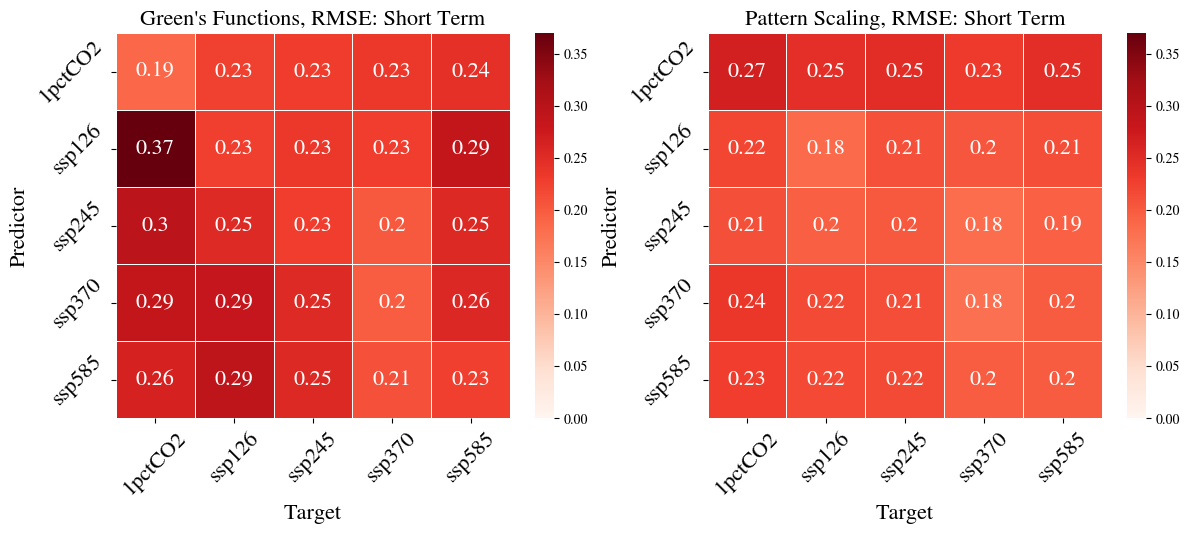

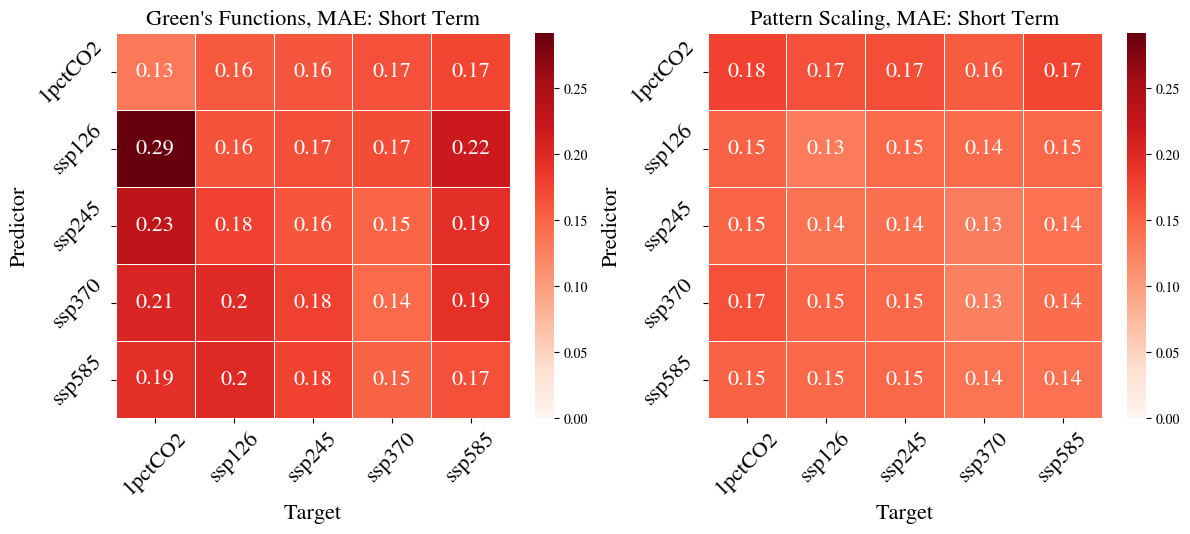

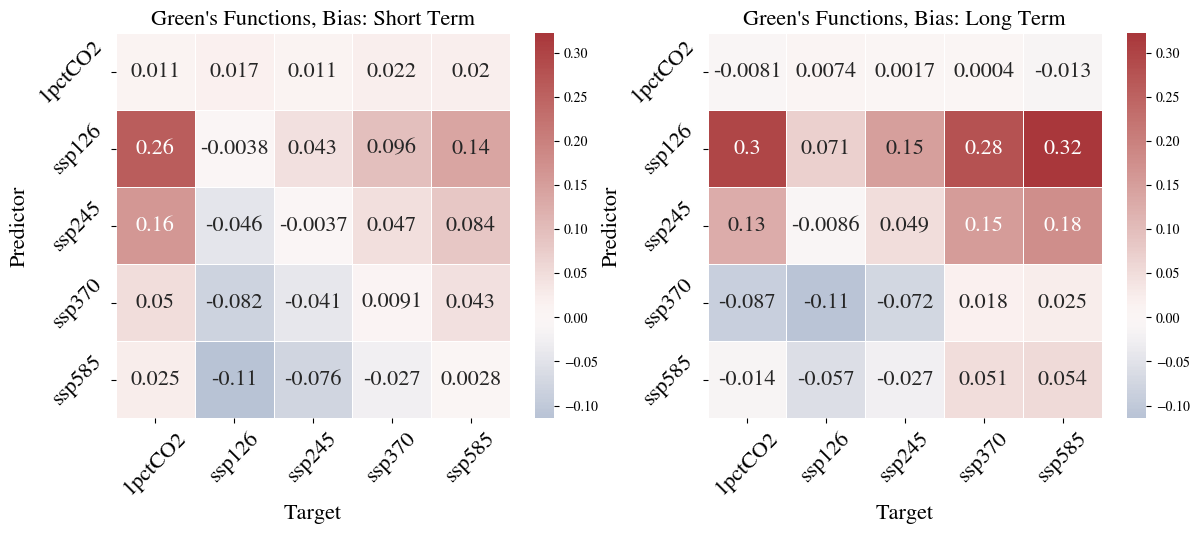

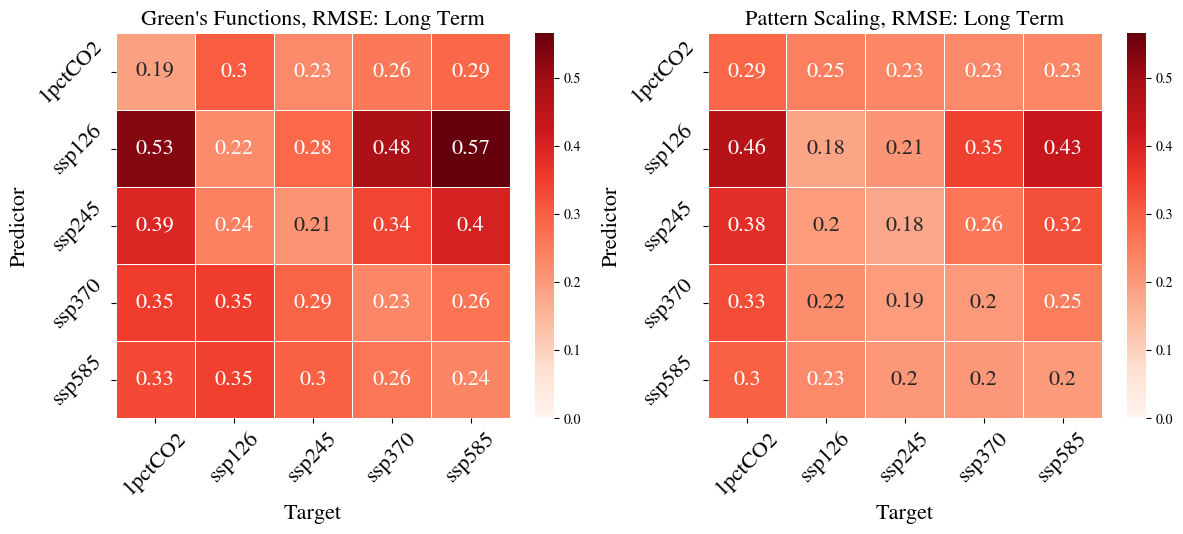

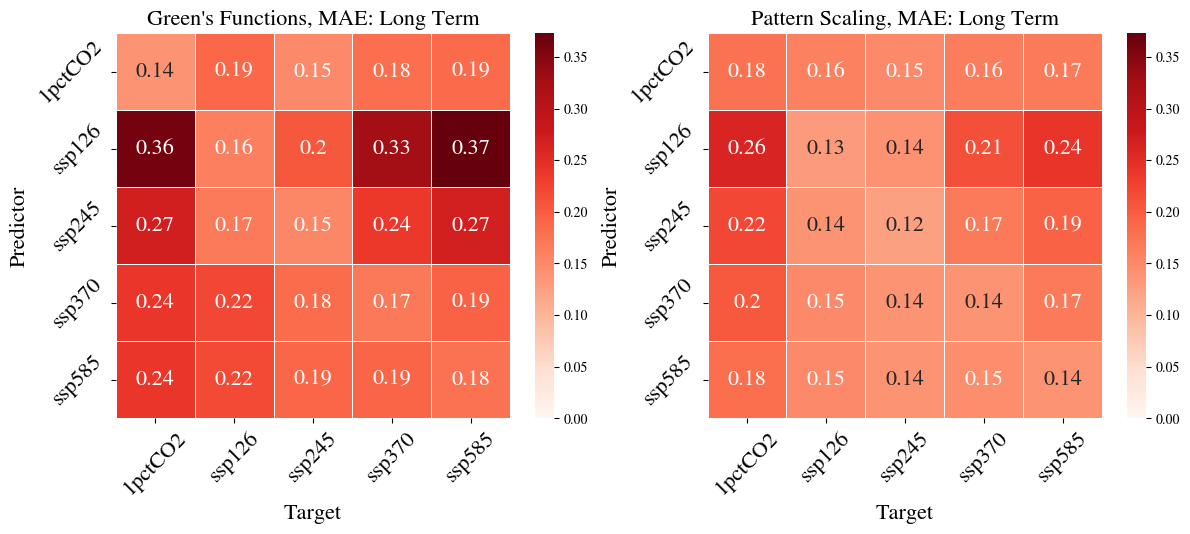

In [10]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures

experiments = ['1pctCO2','ssp126','ssp245','ssp370','ssp585']
save = False

def plot_res(data1, data2, experiments, title, plot_title = None):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (14,5))
    if 'Bias' in title:
        cmap = 'vlag'
        vmin = np.min([data1,data2])
        vmax = np.max([data1,data2])
    else:
        cmap = 'Reds'
        vmin = 0
        
    vmax = np.max([data1,data2])
    
    if title == 'Bias':
        sns.heatmap(data1, ax = ax1, vmin = vmin, vmax = vmax, annot = True, cmap = cmap, center = 0.0, linewidth=0.5, yticklabels=experiments, xticklabels=experiments,  annot_kws={"fontsize":16})
        sns.heatmap(data2, ax = ax2, vmin = vmin, vmax = vmax, annot = True, cmap = cmap, center = 0.0, linewidth=0.5, yticklabels=experiments, xticklabels=experiments,  annot_kws={"fontsize":16})
    else: 
        sns.heatmap(data1, ax = ax1, vmin = vmin, vmax = vmax, annot = True, cmap = cmap, linewidth=0.5, yticklabels=experiments, xticklabels=experiments, annot_kws={"fontsize":16})
        sns.heatmap(data2, ax = ax2, vmin = vmin, vmax = vmax, annot = True, cmap = cmap, linewidth=0.5, yticklabels=experiments, xticklabels=experiments, annot_kws={"fontsize":16})
    
    if title == 'Bias':
        ax1.set_title(f'Green\'s Functions, {title}: Short Term',fontsize = 16)
    else:
        ax1.set_title(f'Green\'s Functions, {title}',fontsize = 16)
    ax1.set_xlabel('Target',fontsize = 16)
    ax1.set_ylabel('Predictor',fontsize = 16)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=45)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    
    if title == 'Bias':
        ax2.set_title(f'Green\'s Functions, {title}: Long Term',fontsize = 16)
    else:
        ax2.set_title(f'Pattern Scaling, {title}',fontsize = 16)
    ax2.set_xlabel('Target',fontsize = 16)
    ax2.set_ylabel('Predictor',fontsize = 16)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation=45)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    
    if plot_title and save:
        plt.savefig(f'{figure_path}heatmap_loess_{plot_title}_v1.pdf', bbox_inches = 'tight', dpi = 350)
    
    return

plot_res(RMSE_all_conv_short, RMSE_all_patt_short, experiments, 'RMSE: Short Term', 'RMSE_short')
plot_res(MAE_all_conv_short, MAE_all_patt_short, experiments, 'MAE: Short Term', 'MAE_short')
plot_res(bias_all_conv_short, bias_all_conv_long, experiments, 'Bias', 'bias_both')

plot_res(RMSE_all_conv_long, RMSE_all_patt_long, experiments, 'RMSE: Long Term', 'RMSE_long')
plot_res(MAE_all_conv_long, MAE_all_patt_long, experiments, 'MAE: Long Term', 'MAE_long')

In [11]:
def calc_area_error(truth_path, emulator_path, start_year, end_year):

    truth = xr.open_dataset(truth_path) 

    if 'patt' in emulator_path:
        emulator = xr.open_dataset(emulator_path)
    else:
        emulator = xr.open_dataset(emulator_path)['__xarray_dataarray_variable__']
        emulator.name = 'tas'
    
    if (start_year == 1875 or start_year == 1915) and 'conv' in emulator_path:
        truth = truth.sel(s = slice(165,250)).assign_coords(s = range(0,85))
    
    slice_start = start_year - 1850
    slice_end = end_year - 1850
    
    truth = truth.mean(dim = 'model')
    truth = truth.sel(s = slice(slice_start,slice_end))    
    
    if 'conv' in emulator_path:
        emulator = emulator.mean(dim = 'train_id')
        
    emulator = emulator.sel(s = slice(slice_start,slice_end))
    
    # For each grid point, calculate % error from truth
    pct_error_spatial = np.divide(np.subtract(emulator,truth['tas']),truth['tas']).mean(dim = 's')
    pct_error_stacked = pct_error_spatial.stack(allpoints=['lat','lon'])
    
    mn = pct_error_spatial.weighted(A).mean(dim = ['lat','lon'])
    std = pct_error_spatial.weighted(A).std(dim = ['lat','lon'])
    
    # Create dataset of total area
    total_area = xr.DataArray(np.ones((len(truth.lon.values),len(truth.lat.values))),
                              coords={'lon': ('lon', truth.lon.values),
                              'lat': ('lat', truth.lat.values)})
    total_area.to_dataset(name = 'area')

    area_pct = []
    area_stack = A.stack(allpoints=['lat','lon'])

    # Create histogram of error by area on the planet 
    n_bins = 100
    if 'patt' in emulator_path:
        counts, bins = np.histogram(pct_error_stacked.tas.values, range = (-0.375,0.375), bins = n_bins)
    else:
        counts, bins = np.histogram(pct_error_stacked.values, range = (-0.375,0.375), bins = n_bins)
    seen = set()
    for i in range(n_bins):
        bin_l = bins[i]
        bin_r = bins[i+1]
        area_count = 0
        for j in range(len(pct_error_stacked['allpoints'].values)):
            if j in seen:
                continue

            if 'patt' in emulator_path:
                test_val = pct_error_stacked.tas.values[j]
            else:
                test_val = pct_error_stacked.values[j]

            if bin_l <= test_val <= bin_r:
                area_count += area_stack[j]
                seen.add(j)

        area_pct.append(area_count)
        
    # Scale each bin by the total surface area of the Earth
    surf_earth = sum(sum(A))
    for i in range(n_bins):
        if type(area_pct[i]) is int:
            area_pct[i] = area_pct[i]/surf_earth
        else:
            area_pct[i] = area_pct[i].values/surf_earth
    
    return area_pct, bins, mn, std

In [12]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

A = ERFutils.A

#conv_id = ['1pctCO2','ssp126','ssp245','ssp370','ssp585']
#train_id = ['ssp126','ssp245','ssp370','ssp585']

conv_id = ['1pctCO2']
train_id = ['ssp245']

area_pct_short, area_pct_long = {}, {}
bins_short, bins_long = {}, {}
max_s_l = {}

save = False

for train in train_id:
    for conv in conv_id:
        truth_path = f'{output_path}tas/tas_CMIP_{conv}_all_ds.nc4'
        emulator_path = f'{output_path}Spatial Results/res_conv_spatial_{train}_{conv}_all_ds.nc4'

        if 'ssp' in conv and 'ssp' not in train:
            start_yr1, end_yr1 = 2040, 2060
            start_yr2, end_yr2 = 2080, 2100
        elif 'ssp' in conv:
            start_yr1, end_yr1 = 1875, 1895
            start_yr2, end_yr2 = 1915, 1935
        else: # 1pctCO2
            start_yr1, end_yr1 = 1940, 1960
            start_yr2, end_yr2 = 1980, 2000

        area_pct_short[conv], bins_short[conv], mn_short, std_short = calc_area_error(truth_path, emulator_path, start_yr1, end_yr1)
        area_pct_long[conv], bins_long[conv], mn_long, std_long = calc_area_error(truth_path, emulator_path, start_yr2, end_yr2)

        max_s_l[conv] = max(float(max(area_pct_short[conv])),float(max(area_pct_long[conv])))
        
        print(f'Short Term - Predictor: {train}, Target: {conv}, mean: {round(float(mn_short),4)}, std: {round(float(std_short),4)}, max: {round(float(max(area_pct_short[conv])),4)}')
        print(f'Long Term - Predictor: {train}, Target: {conv}, mean: {round(float(mn_long),4)}, std: {round(float(std_long),4)}, max: {round(float(max(area_pct_long[conv])),4)}')
        
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (14,5))
    for conv in conv_id:
        ax1.stairs(area_pct_short[conv], bins_short[conv], label = f'Target: {conv}', linewidth = 1.5)
        ax2.stairs(area_pct_long[conv], bins_long[conv], label = f'Target: {conv}', linewidth = 1.5)

    max_max = max([max_s_l[k] for k in max_s_l.keys()])
        
    ax1.set_ylim(0,max_max*1.05)
    ax1.set_xlabel('Relative Error',fontsize=16)
    ax1.set_xticks(ticks = [-0.375,-0.25,-0.125,0,0.125,0.25,0.375],labels = ['-37.5%','-25%','-12.5%','0%','12.5%','25%','37.5%'])
    ax1.set_ylabel('% Surface Area',fontsize=16)
    ax1.set_title(f'Green\'s Functions, Predictor: {train}, Short Term',fontsize=16)
    ax1.legend(fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ax2.set_ylim(0,max_max*1.05)
    ax2.set_xlabel('Relative Error',fontsize=16)
    ax2.set_xticks(ticks = [-0.375,-0.25,-0.125,0,0.125,0.25,0.375],labels = ['-37.5%','-25%','-12.5%','0%','12.5%','25%','37.5%'])
    ax2.set_ylabel('% Surface Area',fontsize=16)
    ax2.set_title(f'Green\'s Functions, Predictor: {train}, Long Term',fontsize=16)
    ax2.legend(fontsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    
    if save:
        plt.savefig(f'{figure_path}area_loess_comp_conv_{train}_v1.pdf', bbox_inches = 'tight', dpi = 350)

KeyboardInterrupt: 

In [ ]:
save = False
if save:
    import pickle
    output_path = ERFutils.path_to_ERF_outputs
    with open(f'{output_path}area_pct_short.pickle', 'wb') as handle:
        pickle.dump(area_pct_short, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_path}area_pct_long.pickle', 'wb') as handle:
        pickle.dump(area_pct_long, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_path}bins_short.pickle', 'wb') as handle:
        pickle.dump(bins_short, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_path}bins_long.pickle', 'wb') as handle:
        pickle.dump(bins_long, handle, protocol=pickle.HIGHEST_PROTOCOL)

GF: Short Term - Predictor: ssp585, Target: ssp585, mean: 0.0143, std: 0.0398, max: 0.1208
GF: Long Term - Predictor: ssp585, Target: ssp585, mean: 0.0172, std: 0.0323, max: 0.1318
PS: Short Term - Predictor: ssp585, Target: ssp585, mean: 0.0144, std: 0.043, max: 0.1339
PS: Long Term - Predictor: ssp585, Target: ssp585, mean: -0.0014, std: 0.0185, max: 0.2385


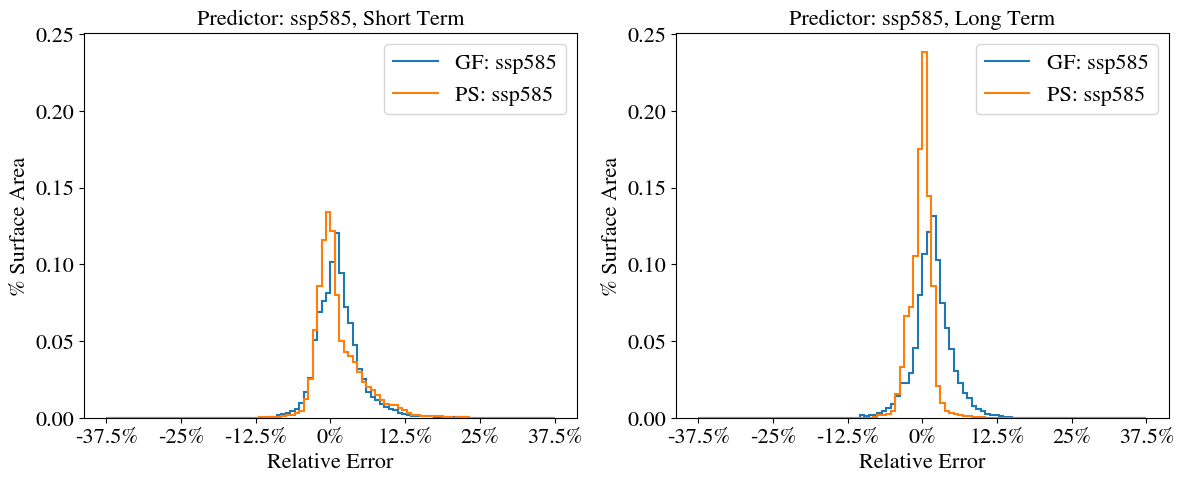

In [17]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

A = ERFutils.A

conv_id = ['ssp585']
train_id = ['ssp585']

area_pct_short_conv, area_pct_long_conv = {}, {}
area_pct_short_patt, area_pct_long_patt = {}, {}
bins_short_conv, bins_long_conv = {}, {}
bins_short_patt, bins_long_patt = {}, {}

save = False

for train in train_id:
    for conv in conv_id:
        truth_path = f'{output_path}tas/tas_CMIP_{conv}_all_ds.nc4'
        emulator_path_conv = f'{output_path}Spatial Results/res_conv_spatial_{train}_{conv}_all_ds.nc4'
        emulator_path_patt = f'{output_path}Spatial Results/res_pattern_spatial_{train}_{conv}_all_ds.nc4'

        if 'ssp' in conv and 'ssp' not in train:
            start_yr1, end_yr1 = 2040, 2060
            start_yr2, end_yr2 = 2080, 2100
            start_yr1_patt, end_yr1_patt, start_yr2_patt, end_yr2_patt = start_yr1, end_yr1, start_yr2, end_yr2
        elif 'ssp' in conv:
            start_yr1, end_yr1 = 1875, 1895
            start_yr2, end_yr2 = 1915, 1935
            
            start_yr1_patt, end_yr1_patt = 2040, 2060
            start_yr2_patt, end_yr2_patt = 2080, 2100
        else: # 1pctCO2
            start_yr1, end_yr1 = 1940, 1960
            start_yr2, end_yr2 = 1980, 2000
            start_yr1_patt, end_yr1_patt, start_yr2_patt, end_yr2_patt = start_yr1, end_yr1, start_yr2, end_yr2

        area_pct_short_conv[conv], bins_short_conv[conv], mn_short_conv, std_short_conv = calc_area_error(truth_path, emulator_path_conv, start_yr1, end_yr1)
        area_pct_long_conv[conv], bins_long_conv[conv], mn_long_conv, std_long_conv = calc_area_error(truth_path, emulator_path_conv, start_yr2, end_yr2)
        
        area_pct_short_patt[conv], bins_short_patt[conv], mn_short_patt, std_short_patt = calc_area_error(truth_path, emulator_path_patt, start_yr1_patt, end_yr1_patt)
        area_pct_long_patt[conv], bins_long_patt[conv], mn_long_patt, std_long_patt = calc_area_error(truth_path, emulator_path_patt, start_yr2_patt, end_yr2_patt)

        print(f'GF: Short Term - Predictor: {train}, Target: {conv}, mean: {round(float(mn_short_conv),4)}, std: {round(float(std_short_conv),4)}, max: {round(float(max(area_pct_short_conv[conv])),4)}')
        print(f'GF: Long Term - Predictor: {train}, Target: {conv}, mean: {round(float(mn_long_conv),4)}, std: {round(float(std_long_conv),4)}, max: {round(float(max(area_pct_long_conv[conv])),4)}')
        
        print(f'PS: Short Term - Predictor: {train}, Target: {conv}, mean: {round(float(mn_short_patt.tas.values),4)}, std: {round(float(std_short_patt.tas.values),4)}, max: {round(float(max(area_pct_short_patt[conv])),4)}')
        print(f'PS: Long Term - Predictor: {train}, Target: {conv}, mean: {round(float(mn_long_patt.tas.values),4)}, std: {round(float(std_long_patt.tas.values),4)}, max: {round(float(max(area_pct_long_patt[conv])),4)}')
        
    max_s_l_conv = max(float(max(area_pct_short_conv[conv])),float(max(area_pct_long_conv[conv])))
    max_s_l_patt = max(float(max(area_pct_short_patt[conv])),float(max(area_pct_long_patt[conv])))
    max_max = max(max_s_l_conv, max_s_l_patt)
        
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (14,5))
    for conv in conv_id:
        ax1.stairs(area_pct_short_conv[conv], bins_short_conv[conv], label = f'GF: {conv}', linewidth = 1.5)
        ax1.stairs(area_pct_short_patt[conv], bins_short_patt[conv], label = f'PS: {conv}', linewidth = 1.5)
        
        ax2.stairs(area_pct_long_conv[conv], bins_long_conv[conv], label = f'GF: {conv}', linewidth = 1.5)
        ax2.stairs(area_pct_long_patt[conv], bins_long_patt[conv], label = f'PS: {conv}', linewidth = 1.5)

    ax1.set_ylim(0,max_max*1.05)
    ax1.set_xlabel('Relative Error',fontsize=16)
    ax1.set_xticks(ticks = [-0.375,-0.25,-0.125,0,0.125,0.25,0.375],labels = ['-37.5%','-25%','-12.5%','0%','12.5%','25%','37.5%'])
    ax1.set_ylabel('% Surface Area',fontsize=16)
    ax1.set_title(f'Predictor: {train}, Short Term',fontsize=16)
    ax1.legend(fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ax2.set_ylim(0,max_max*1.05)
    ax2.set_xlabel('Relative Error',fontsize=16)
    ax2.set_xticks(ticks = [-0.375,-0.25,-0.125,0,0.125,0.25,0.375],labels = ['-37.5%','-25%','-12.5%','0%','12.5%','25%','37.5%'])
    ax2.set_ylabel('% Surface Area',fontsize=16)
    ax2.set_title(f'Predictor: {train}, Long Term',fontsize=16)
    ax2.legend(fontsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    
    if save:
        plt.savefig(f'{figure_path}area_comp_conv_patt_loess_{train}_{conv}_v1.pdf', bbox_inches = 'tight', dpi = 350)
    
    

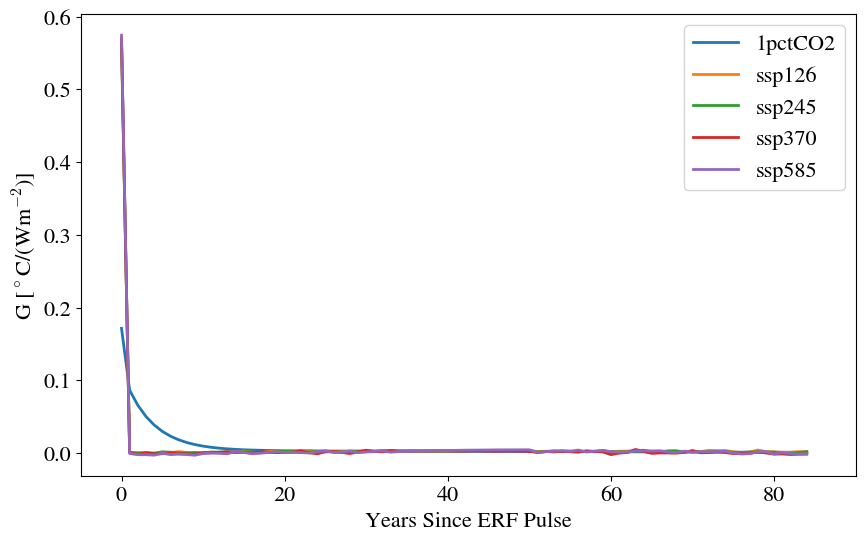

In [26]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
save = False

train_id = ['1pctCO2','ssp126','ssp245','ssp370','ssp585']
A = ERFutils.A

fig, ax = plt.subplots(figsize = [10,6])
for train in train_id:
    if train == '1pctCO2':
        G_ds_path = f'{output_path}GFs/G_loess_{train}_ERF_mean_ds.nc4'
        G_ds = xr.open_dataset(G_ds_path)['G[tas]']
    else:
        G_ds_path = f'{output_path}GFs/G_{train}_ERF_all_ds.nc4'
        G_ds = xr.open_dataset(G_ds_path)['__xarray_dataarray_variable__']
    G_ds.name = 'G'
    
    if train == '1pctCO2':
        G_ds = G_ds.sel(year  = slice(0,84))
        ax.plot(G_ds.weighted(A).mean(dim = ['lat','lon']).values, label = train, linewidth=2)
    else:
        ax.plot(G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'model').values, label = train, linewidth=2)
    
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('Years Since ERF Pulse',fontsize=16)
ax.set_ylabel('G [$^\circ$C/(Wm$^{-2}$)]',fontsize=16)
ax.set_xlim([-5,90])
ax.legend(fontsize=16)

if save:
    plt.savefig(f'{figure_path}GF_all_loess_v1.pdf', bbox_inches = 'tight', dpi = 350)

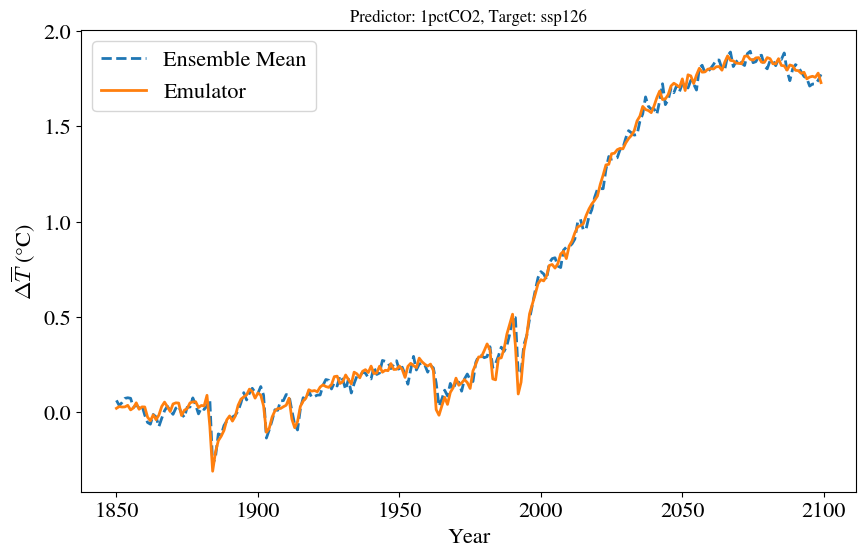

In [26]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
save = False

train_id = ['1pctCO2']#,'ssp126','ssp245','ssp370','ssp585']
conv_id = ['ssp126']#,'ssp126','ssp245','ssp370','ssp585']

for train in train_id:
    for conv in conv_id:

        tas_CMIP_path = f'{output_path}tas/tas_CMIP_{conv}_all_ds.nc4'
        tas_CMIP = xr.open_dataset(tas_CMIP_path)

        conv_ds_path = f'{output_path}Spatial Results/res_conv_spatial_{train}_{conv}_all_ds.nc4'
        conv_ds = xr.open_dataset(conv_ds_path)['__xarray_dataarray_variable__']

        conv_mean_ds_path = f'{output_path}Global Mean Results/res_conv_global_{train}_{conv}_all_ds.nc4'
        conv_mean_ds = xr.open_dataset(conv_mean_ds_path)['__xarray_dataarray_variable__']

        if 'ssp' in conv and 'ssp' in train:
            tas_CMIP = tas_CMIP.sel(s = slice(165,250)).assign_coords(s = range(0,85))

        if 'ssp' in conv and 'ssp' not in train:
            start_yr1, plot_yr1, end_yr1 = 2040, 2050, 2060
            start_yr2, plot_yr2, end_yr2 = 2080, 2090, 2100
        elif 'ssp' in conv:
            start_yr1, plot_yr1, end_yr1 = 1875, 1885, 1895
            start_yr2, plot_yr2, end_yr2 = 1915, 1925, 1935
        elif 'hist' in conv:
            start_yr, plot_yr, end_yr = 1850, 1975, 2015
        else: # 1pctCO2
            start_yr1, plot_yr1, end_yr1 = 1940, 1950, 1960
            start_yr2, plot_yr2, end_yr2 = 1980, 1990, 2000

        # Make plots for analysis
        model_color = ERFutils.model_color
        type_color = ERFutils.type_color
        ERFutils.plot_conv_meanGF(train, conv, conv_mean_ds, tas_CMIP, save_fig = save)
        #ERFutils.plot_dif_map_meanGF(conv_ds, tas_CMIP, plot_yr = plot_yr1, yr_dif = 10, train_id = train, conv_id = conv, save_fig = save)
        #ERFutils.plot_dif_map_meanGF(conv_ds, tas_CMIP, plot_yr = plot_yr2, yr_dif = 10, train_id = train, conv_id = conv, save_fig = save)